In [128]:
#Importing Libraries
import numpy as np
import pandas as pd
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
import tensorflow as tf
import keras_metrics
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import math
import datetime as dt
from keras.layers import Dense, Activation, BatchNormalization, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras import optimizers

In [129]:
test_dataset = pd.read_csv('PatientData591test.csv', header = 0, index_col = 0)
test_dataset.columns

Index([' glucose_level', ' finger_stick_value', ' basal_value',
       'temp_basal_value', ' bolus_dose', ' bolus_carb_input', ' meal_carbs',
       ' sleep_quality', ' duration', ' intensity', ' basis_heartrate_value',
       ' basis_gsr_value', ' basis_skin_temp_value', 'basis_air_temp',
       ' basis_steps', ' basis_sleep_quality'],
      dtype='object')

In [130]:
# load dataset
dataset = pd.read_csv('PatientDataAll.csv', header=0, index_col=0)
values=dataset.values
dataset.columns

Index([' glucose_level', ' finger_stick_value', ' basal_value',
       'temp_basal_value', ' bolus_dose', ' bolus_carb_input', 'meal_carbs',
       'sleep_quality', 'duration', 'intensity', 'basis_heartrate_value',
       'basis_gsr_value', 'basis_skin_temp_value', 'basis_air_temp',
       'basis_steps', 'basis_sleep_quality'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

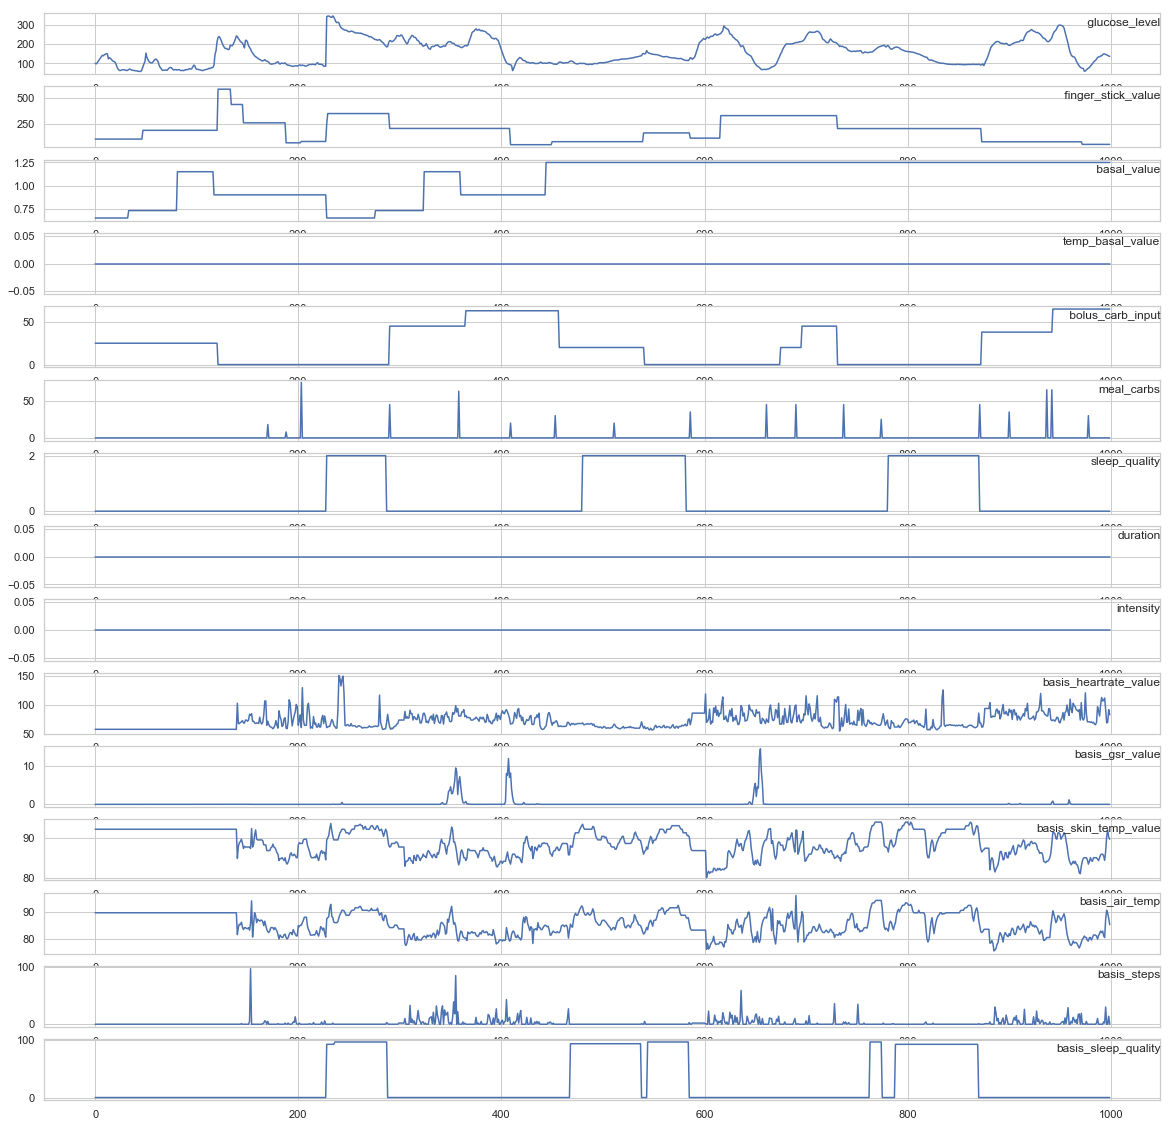

In [131]:
from matplotlib import pyplot
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
i = 1
# plot each column
pyplot.figure()
pyplot.figure(figsize=(20,20))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:1000, group])
	pyplot.title(dataset.columns[group], y=0.7, loc='right')
	i += 1
pyplot.show()

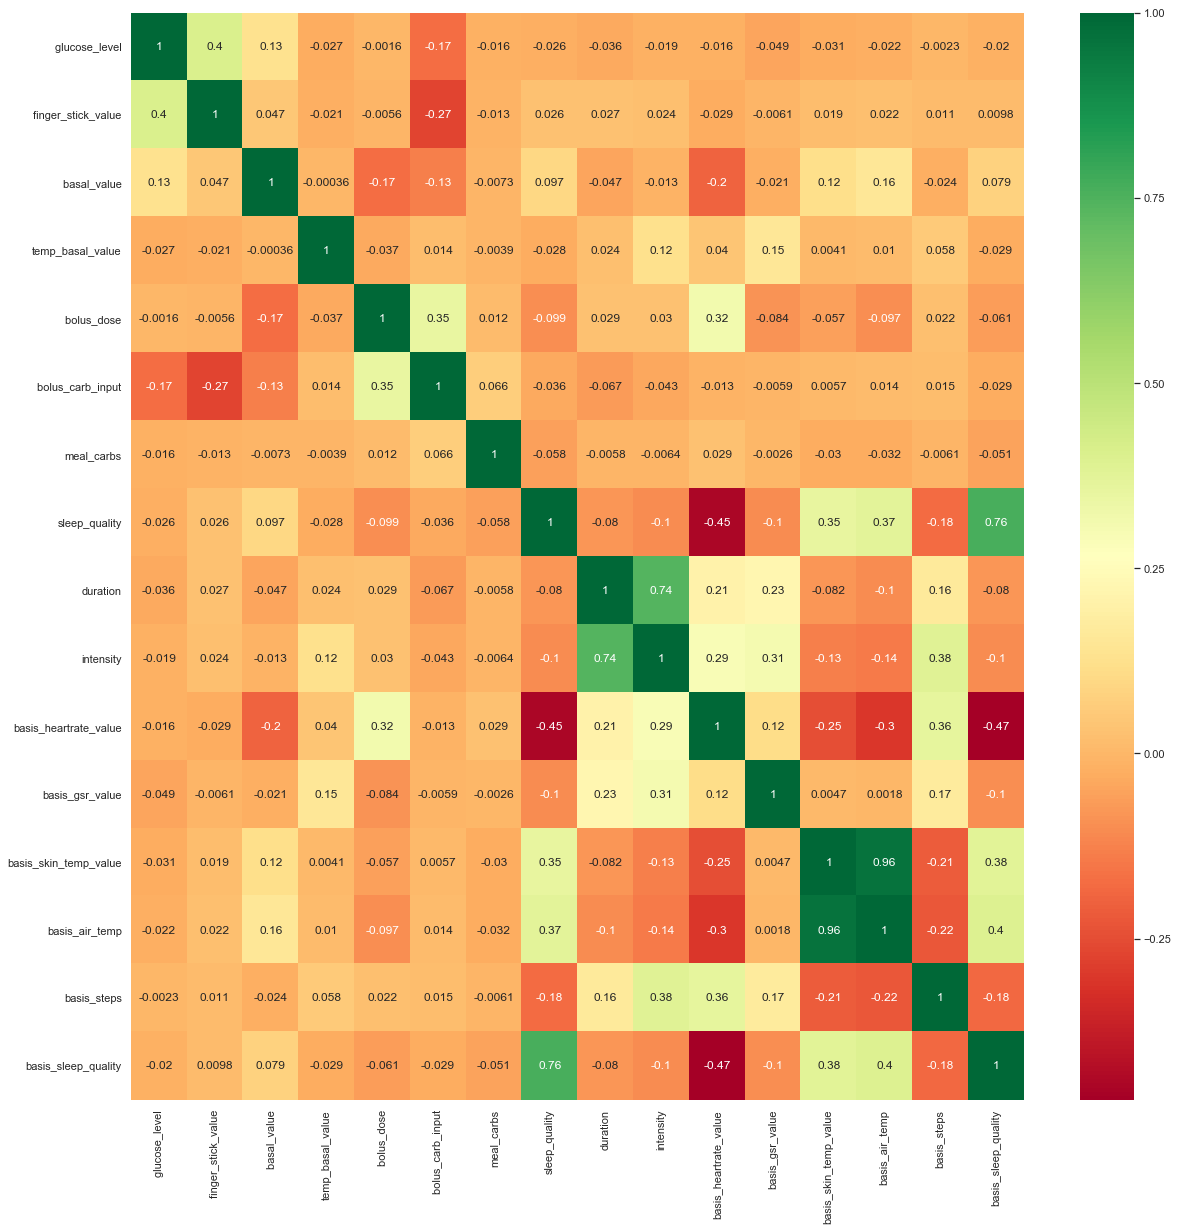

In [132]:
#correlation among independant variables of full dataset of required variables
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
X = dataset #independent columns

#get correlations of each features in dataset
corrmat = pd.DataFrame(X).corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(pd.DataFrame(X[top_corr_features]).corr(),annot=True,cmap="RdYlGn")
g=sns.heatmap(pd.DataFrame(X).corr(),annot=True,cmap="RdYlGn")

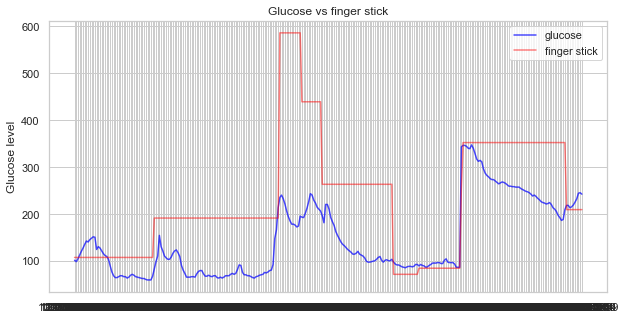

In [133]:
plt.figure(figsize=(10,5))
plt.plot(dataset[' glucose_level'][0:300], color ='blue', alpha = 0.7,label = "glucose")
plt.plot(dataset[' finger_stick_value'][0:300],color='red',alpha = 0.5, label = "finger stick")
plt.legend()
plt.ylabel("Glucose level")

plt.title("Glucose vs finger stick")
plt.show()

In [134]:
df1=dataset.drop([' bolus_dose',' bolus_carb_input', 'meal_carbs',
       'sleep_quality', 'duration', 'intensity', 'basis_heartrate_value',
       'basis_gsr_value', 'basis_skin_temp_value', 'basis_air_temp',
       'basis_steps', 'basis_sleep_quality','temp_basal_value'], axis =1)
df1.head()

,glucose_level,finger_stick_value,basal_value
time_glucose,,,
12/7/2021 1:17,101,107,0.65
12/7/2021 1:22,98,107,0.65
12/7/2021 1:27,104,107,0.65
12/7/2021 1:32,112,107,0.65
12/7/2021 1:37,120,107,0.65


In [135]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [136]:
for i in range(6,0,-1):
    print(i)

6
5
4
3
2
1


### Predict 30 minutes glucose using 30 minutes of historic glucose, finger stick and basal value

In [137]:
df5= series_to_supervised(df1,6,6)

In [138]:
df5.drop(df5.columns[[35,34,32,31,29,28,26,25,23,22,20,19]], axis=1, inplace=True)
df5.head()

,var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),var2(t-4),var3(t-4),var1(t-3),...,var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
time_glucose,,,,,,,,,,,,,,,,,,,,,
12/7/2021 1:47,101.0,107.0,0.65,98.0,107.0,0.65,104.0,107.0,0.65,112.0,...,0.65,127.0,107.0,0.65,135,142.0,140.0,145.0,148.0,151.0
12/7/2021 1:52,98.0,107.0,0.65,104.0,107.0,0.65,112.0,107.0,0.65,120.0,...,0.65,135.0,107.0,0.65,142,140.0,145.0,148.0,151.0,150.0
12/7/2021 1:57,104.0,107.0,0.65,112.0,107.0,0.65,120.0,107.0,0.65,127.0,...,0.65,142.0,107.0,0.65,140,145.0,148.0,151.0,150.0,124.0
12/7/2021 2:02,112.0,107.0,0.65,120.0,107.0,0.65,127.0,107.0,0.65,135.0,...,0.65,140.0,107.0,0.65,145,148.0,151.0,150.0,124.0,130.0
12/7/2021 2:07,120.0,107.0,0.65,127.0,107.0,0.65,135.0,107.0,0.65,142.0,...,0.65,145.0,107.0,0.65,148,151.0,150.0,124.0,130.0,127.0


In [140]:
# ensure all data is float
values5 = df5.values
values5 = values5.astype('float32')
#test_values = test_values.astype('float32')

# normalize features
scaler = StandardScaler()
#scaler_df = MinMaxScaler(feature_range=(0, 1))

scaled5 = scaler.fit_transform(values5)
#test_scaled = scaler.fit_transform(test_values)


In [141]:
scaled5.shape

(67055, 24)

In [142]:
# train the training set and test the testing set
train5=scaled5
#test5=test_reframed.values

split_v= round(len(train5)*0.60)
split_t= round(len(train5)*0.80)

# split into input and outputs
train_X0, train_y0 = train5[:split_v, :-5], train5[:split_v, -5:]
val_X0, val_y0 = train5[split_v:split_t,:-5], train5[split_v:split_t,-5:]
test_X0, test_y0 = train5[split_t:, :-5], train5[split_t:, -5:]

#train_y=np.asarray(train_y0).reshape(( -1 , 1 ))
#val_y=np.asarray(val_y0).reshape(( -1 , 1 ))
#test_y=np.asarray(test_y0).reshape(( -1 , 1 ))

# reshape input to be 3D [samples, timesteps, features]
train_X0 = train_X0.reshape((train_X0.shape[0], 1, train_X0.shape[1]))
val_X0 = val_X0.reshape((val_X0.shape[0], 1, val_X0.shape[1]))
test_X0= test_X0.reshape((test_X0.shape[0], 1, test_X0.shape[1]))
print("Train X shape: ", train_X0.shape)
print("Train y shape: ", train_y0.shape)
print("Validation X shape: ", val_X0.shape)
print("Validation y shape: ", val_y0.shape)
print("Test X shape: ", test_X0.shape)
print("Test y shape: ", test_y0.shape)

Train X shape:  (40233, 1, 19)
Train y shape:  (40233, 5)
Validation X shape:  (13411, 1, 19)
Validation y shape:  (13411, 5)
Test X shape:  (13411, 1, 19)
Test y shape:  (13411, 5)


In [143]:
# design network
model = Sequential()

#model.add(BatchNormalization(input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(128, input_shape=(train_X0.shape[1], train_X0.shape[2])))
model.add(BatchNormalization())
#model.add(TimeDistributed(Dense(output_dim=1, activation='linear')))
model.add(Dense(5))
model.add(Activation("linear"))

rmsprop = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08)
model.compile(loss = 'mse', 
             optimizer = rmsprop)
model.summary()


callbacks = [
        EarlyStopping(monitor='val_loss', patience=20)
        #ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
        ]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128)               75776     
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
_________________________________________________________________
activation_11 (Activation)   (None, 5)                 0         
Total params: 76,933
Trainable params: 76,677
Non-trainable params: 256
_________________________________________________________________


Train on 40233 samples, validate on 13411 samples
Epoch 1/4
40233/40233 [==============================] - 4s 109us/step - loss: 0.1693 - val_loss: 0.0905
Epoch 2/4
40233/40233 [==============================] - 3s 79us/step - loss: 0.0948 - val_loss: 0.0851
Epoch 3/4
40233/40233 [==============================] - 3s 77us/step - loss: 0.0906 - val_loss: 0.0808
Epoch 4/4
40233/40233 [==============================] - 3s 77us/step - loss: 0.0862 - val_loss: 0.0818


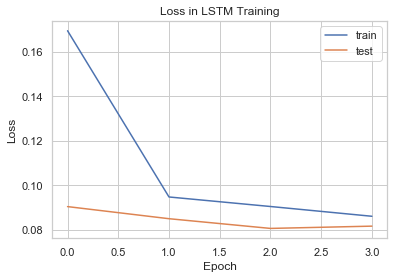

In [144]:
# fit network
history = model.fit(train_X0, train_y0, epochs= 4, batch_size=32, validation_data=(val_X0, val_y0) ,
                callbacks=callbacks)

                #  , verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Loss in LSTM Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## get RMSE of val_X0

In [115]:
# make a prediction
yhat = model.predict(val_X0)
val_X1 = val_X0.reshape((val_X0.shape[0], val_X0.shape[2]))

# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = concatenate((val_X1,yhat ), axis=1)

inv_yhat1 = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat1[:,-5:]

# invert scaling for actual


#val_y = val_y.reshape((len(val_y), 1))
#inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = concatenate((val_X1,val_y0), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:,-5:]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y1, inv_yhat1))
rmse

16.89633525411742

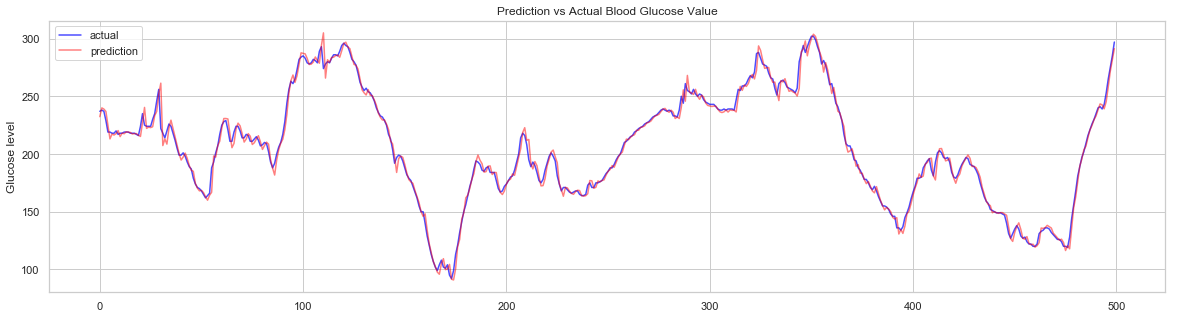

In [124]:
plt.figure(figsize=(20,5))
plt.plot(inv_y[0:500,-5], color ='blue', alpha = 0.7,label = "actual")
plt.plot(inv_yhat1[0:500,-5],color='red',alpha = 0.5, label = "prediction")
plt.legend()
plt.ylabel("Glucose level")
plt.title("Prediction vs Actual Blood Glucose Value")
plt.show()

## get RMSE of test_X0

In [117]:
# make a prediction
yhat = model.predict(test_X0)
test_X1 = test_X0.reshape((test_X0.shape[0], test_X0.shape[2]))

# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = concatenate((test_X1,yhat ), axis=1)

inv_yhat1 = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat1[:,-5:]

# invert scaling for actual


#val_y = val_y.reshape((len(val_y), 1))
#inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = concatenate((test_X1,test_y0), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:,-5:]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y1, inv_yhat1))
rmse

16.869258101543302

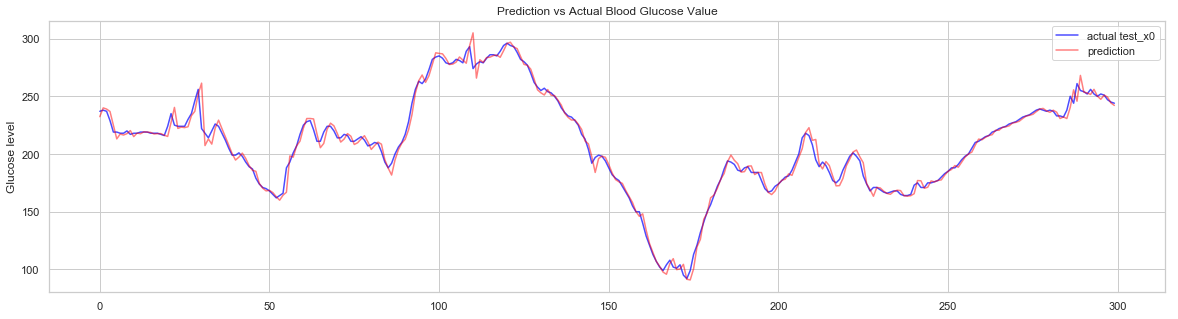

In [118]:
plt.figure(figsize=(20,5))
plt.plot(inv_y[0:300,-5], color ='blue', alpha = 0.7,label = "actual test_x0")
plt.plot(inv_yhat1[0:300,-5],color='red',alpha = 0.5, label = "prediction")
plt.legend()
plt.ylabel("Glucose level")
plt.title("Prediction vs Actual Blood Glucose Value")
plt.show()

In [119]:
inv_yhat1[0,-5:]

array([232.34657, 229.75017, 231.91458, 232.21953, 230.5777 ],
      dtype=float32)

In [120]:
inv_y[1:6,-6]

array([237., 238., 237., 229., 219.], dtype=float32)

In [121]:
inv_y1[0]

array([237., 238., 237., 229., 219.], dtype=float32)

In [122]:
list_rmse = []
for i in range(len(inv_y)-5):
    actual = inv_y[i+1:i+6,0]
    pred = inv_yhat1[i,-5:]
    #print("Actual: ",actual)
    #print("Prediction: ",pred)
    rmse = sqrt(mean_squared_error(actual, pred))
    list_rmse.append(rmse)
sum(list_rmse) / float(len(list_rmse))

17.818430795176003

## One past glucose, finger stick, and basal and one future glucose

In [9]:
#Load test dataset
test_dataset = pd.read_csv('PatientData591test.csv', header = 0, index_col = 0)
df_test=test_dataset.drop([' bolus_dose', ' bolus_carb_input', ' meal_carbs',
       ' sleep_quality', ' duration', ' intensity', ' basis_heartrate_value',
       ' basis_gsr_value', ' basis_skin_temp_value', 'basis_air_temp',
       ' basis_steps', ' basis_sleep_quality','temp_basal_value'], axis =1)

test_values = df_test.values

# ensure all data is float
values = df1.values
values = values.astype('float32')
test_values = test_values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_df = MinMaxScaler(feature_range=(0, 1))

scaled = scaler.fit_transform(values)
test_scaled = scaler.fit_transform(test_values)

#df = scaler_df.fit_transform(df1)

#convert to supervised series
reframed = series_to_supervised(scaled,1,1)
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)

test_reframed = series_to_supervised(test_scaled,1,1)
test_reframed.drop(test_reframed.columns[[4,5]], axis=1, inplace=True)

reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t)
1,0.169444,0.136937,0.173913,0.161111
2,0.161111,0.136937,0.173913,0.177778
3,0.177778,0.136937,0.173913,0.200000
4,0.200000,0.136937,0.173913,0.222222
5,0.222222,0.136937,0.173913,0.241667


In [12]:
# train the training set and test the testing set
train=reframed.values
test=test_reframed.values

split= round(len(train)*0.75)

# split into input and outputs
train_X0, train_y0 = train[:split, :-1], train[:split, -1]
val_X0, val_y0 = train[split:,:-1], train[split:,-1]
test_X0, test_y0 = test[:, :-1], test[:, -1]

train_y=np.asarray(train_y0).reshape(( -1 , 1 ))
val_y=np.asarray(val_y0).reshape(( -1 , 1 ))
test_y=np.asarray(test_y0).reshape(( -1 , 1 ))

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X0.reshape((train_X0.shape[0], 1, train_X0.shape[1]))
val_X = val_X0.reshape((val_X0.shape[0], 1, val_X0.shape[1]))
test_X = test_X0.reshape((test_X0.shape[0], 1, test_X0.shape[1]))
print("Train X shape: ", train_X.shape)
print("Train y shape: ", train_y.shape)
print("Validation X shape: ", val_X.shape)
print("Validation y shape: ", val_y.shape)
print("Test X shape: ", test_X.shape)
print("Test y shape: ", test_y.shape)

Train X shape:  (50299, 1, 3)
Train y shape:  (50299, 1)
Validation X shape:  (16766, 1, 3)
Validation y shape:  (16766, 1)
Test X shape:  (2759, 1, 3)
Test y shape:  (2759, 1)


In [13]:
train_X

array([[[0.16944447, 0.13693695, 0.17391303]],

       [[0.16111112, 0.13693695, 0.17391303]],

       [[0.1777778 , 0.13693695, 0.17391303]],

       ...,

       [[0.3388889 , 0.13873874, 0.6956521 ]],

       [[0.34444445, 0.13873874, 0.6956521 ]],

       [[0.34722224, 0.13873874, 0.6956521 ]]], dtype=float32)

In [16]:
# design network
model = Sequential()

#model.add(BatchNormalization(input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(BatchNormalization())
#model.add(TimeDistributed(Dense(output_dim=1, activation='linear')))
model.add(Dense(1))
model.add(Activation("linear"))

rmsprop = optimizers.RMSprop(lr=0.00001, rho=0.9, epsilon=1e-08)
model.compile(loss = 'mse', 
             optimizer = rmsprop)
model.summary()


callbacks = [
        EarlyStopping(monitor='val_loss', patience=20)
        #ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
        ]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               41600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 42,101
Trainable params: 41,901
Non-trainable params: 200
_________________________________________________________________


from keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='loss',min_delta=0.000000000001,patience=30)

rates = [0.001,0.0001,0.00001]
for rate in rates:
    print('training with lr = ' + str(rate))
    rmsprop = optimizers.RMSprop(lr=rate, rho=0.9, epsilon=None, decay=0.0)
    adam=optimizers.Adam
    model.compile(loss='mse', optimizer=adam(lr=rate))
    #model.compile(loss = 'mse', 
         #     optimizer = rmsprop)
    model.fit(train_X,train_y,epochs=10,callbacks=[stop],verbose=2) #train indefinitely until loss stops decreasing
    print('\n\n')

Train on 50299 samples, validate on 16766 samples
Epoch 1/10
50299/50299 [==============================] - 11s 209us/step - loss: 0.0990 - val_loss: 0.0162
Epoch 2/10
50299/50299 [==============================] - 9s 175us/step - loss: 0.0051 - val_loss: 4.7094e-04
Epoch 3/10
50299/50299 [==============================] - 9s 176us/step - loss: 0.0014 - val_loss: 4.6025e-04
Epoch 4/10
50299/50299 [==============================] - 9s 177us/step - loss: 0.0013 - val_loss: 4.7562e-04
Epoch 5/10
50299/50299 [==============================] - 9s 176us/step - loss: 0.0013 - val_loss: 4.5800e-04
Epoch 6/10
50299/50299 [==============================] - 9s 175us/step - loss: 0.0013 - val_loss: 4.5676e-04
Epoch 7/10
50299/50299 [==============================] - 9s 177us/step - loss: 0.0013 - val_loss: 4.5529e-04
Epoch 8/10
50299/50299 [==============================] - 9s 178us/step - loss: 0.0012 - val_loss: 4.4795e-04
Epoch 9/10
50299/50299 [==============================] - 9s 185us/step -

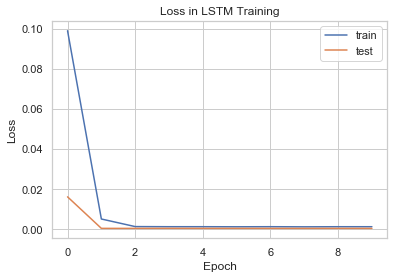

In [17]:
# fit network
history = model.fit(train_X, train_y, epochs= 10, batch_size=32, validation_data=(val_X, val_y) ,
                callbacks=callbacks)

                #  , verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Loss in LSTM Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [18]:
# make a prediction
yhat = model.predict(val_X)

In [19]:
yhat

array([[0.33995438],
       [0.33995438],
       [0.33716974],
       ...,
       [0.14468467],
       [0.15016684],
       [0.16113636]], dtype=float32)

In [20]:
val_X1 = val_X.reshape((val_X.shape[0], val_X.shape[2]))

# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = concatenate((yhat, val_X1[:,1:]), axis=1)

In [21]:
inv_yhat1 = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat1[:,0]

# invert scaling for actual


#val_y = val_y.reshape((len(val_y), 1))
#inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = concatenate((val_y, val_X1[:,1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat1))
rmse

5.259376145995679

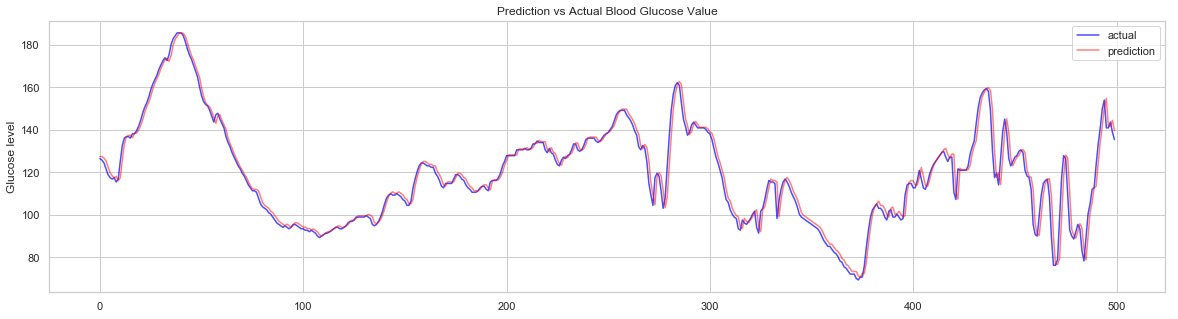

In [22]:
plt.figure(figsize=(20,5))
plt.plot(inv_y[0:500], color ='blue', alpha = 0.7,label = "actual")
plt.plot(inv_yhat1[0:500],color='red',alpha = 0.5, label = "prediction")
plt.legend()
plt.ylabel("Glucose level")
plt.title("Prediction vs Actual Blood Glucose Value")
plt.show()

### Using test set

In [25]:
# make a prediction on test set
yhat = model.predict(test_X)

test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = concatenate((yhat, test_X1[:,1:]), axis=1)

inv_yhat1 = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat1[:,0]

# invert scaling for actual


#val_y = val_y.reshape((len(val_y), 1))
#inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = concatenate((test_y, test_X1[:,1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat1))
rmse

6.295633577030231

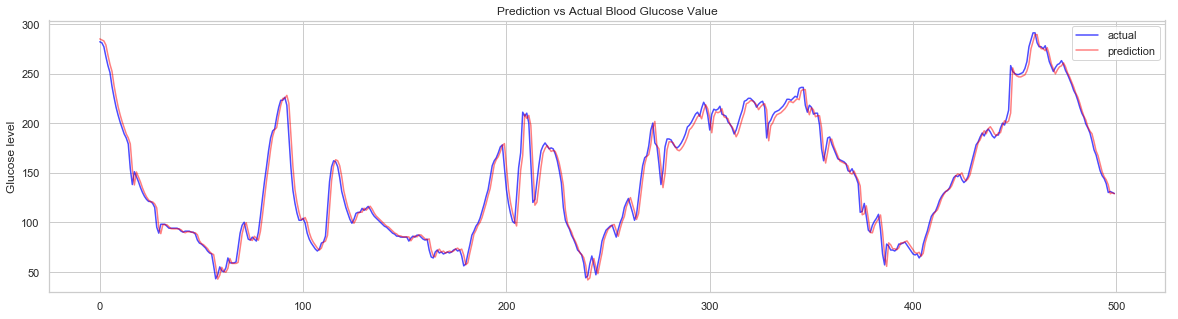

In [26]:
plt.figure(figsize=(20,5))
plt.plot(inv_y[0:500], color ='blue', alpha = 0.7,label = "actual")
plt.plot(inv_yhat1[0:500],color='red',alpha = 0.5, label = "prediction")
plt.legend()
plt.ylabel("Glucose level")
plt.title("Prediction vs Actual Blood Glucose Value")
plt.show()

## Only Glucose

In [125]:
def series_to_supervised(sequence, steps_in,steps_out):
    
    X,y = list(), list()
    for i in range(len(sequence)-steps_in-1):
        target = i + steps
        if target > len(sequence)-2:
            break
        seq_x = sequence[i:target]
            
        seq_y = sequence[target+steps_out]
        
        X.append(seq_x)
        y.append(seq_y)
        
        
    return X,y
            

(53648, 1, 5) (53648,) (13412, 1, 5) (13412,)
Train on 53648 samples, validate on 13412 samples
Epoch 1/10
53648/53648 [==============================] - 11s 211us/step - loss: 0.0033 - val_loss: 0.0013
Epoch 2/10
53648/53648 [==============================] - 9s 160us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/10
53648/53648 [==============================] - 9s 163us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/10
53648/53648 [==============================] - 9s 163us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/10
53648/53648 [==============================] - 9s 165us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/10
53648/53648 [==============================] - 9s 169us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/10
53648/53648 [==============================] - 9s 164us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/10
53648/53648 [==============================] - 9s 168us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/10
53648/53648 [==============================]

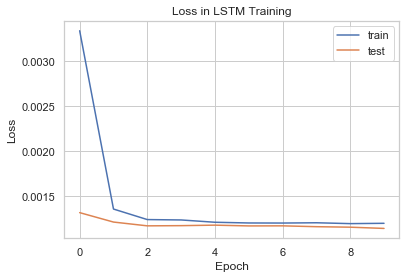

In [58]:
glucose=values[:,0]
X,y=series_to_supervised(glucose, 5)
split_point = round(len(X)*0.8)

df = pd.DataFrame(X)
df['target']= y
df
# normalize features
scaler1 = MinMaxScaler(feature_range=(0, 1))
data = scaler1.fit_transform(df)
X=data[:,:-1]
y=data[:,-1]

train_X, train_y = X[:split_point], y[:split_point]
test_X, test_y = X[split_point:], y[split_point:]

train_X=np.asarray(train_X)
test_X=np.asarray(test_X)

train_y=np.asarray(train_y)
test_y=np.asarray(test_y)



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(100, activation = 'linear', input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(BatchNormalization()) 
model.add(Dropout(0.5))
#model.add(LSTM(256))
#model.add(Dropout(0.5))
model.add(Dense(1))
#model.add(Activation("linear"))
model.compile(loss = "mse", 
              optimizer = "adam")
#model.summary()


#model.add(Dense(Y_modified.shape[1], activation='softmax'))
#model.add(Dense(1))

#model.compile(optimizer='adam',loss='mean_squared_error')

# fit network
history = model.fit(train_X, train_y, epochs= 10, batch_size=16, validation_data=(test_X, test_y))#  , verbose=2, shuffle=False)
#history = model.fit(train_X, train_y, epochs= 5, batch_size=256)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Loss in LSTM Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [59]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = concatenate((yhat, test_X), axis=1)
inv_yhat1 = scaler1.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat1[:,0]

# invert scaling for actual

test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler1.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat1))
rmse

12.16831690630548

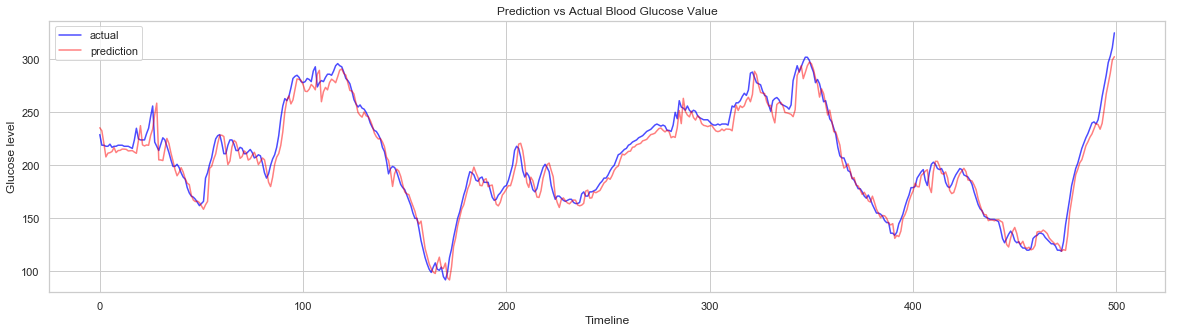

In [62]:
plt.figure(figsize=(20,5))
plt.plot(inv_y[:500], color ='blue', alpha = 0.7,label = "actual")
plt.plot(inv_yhat1[:500],color='red',alpha = 0.5, label = "prediction")
plt.legend()
plt.ylabel("Glucose level")
plt.xlabel("Timeline")
plt.title("Prediction vs Actual Blood Glucose Value")
plt.show()